In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
project_dir = "/codespace/braintypicality"
sys.path.append(project_dir)

In [2]:
import functools
import glob
import math
import torch
import ants
import antspynet
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as mcolors


from functools import partial
from scipy.ndimage import median_filter
import skimage.filters as skf
from scipy.stats import percentileofscore

import yaml
from nilearn import datasets, plotting
import os 

2024-03-14 18:40:51.892268: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 18:40:51.892308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 18:40:51.893377: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 18:40:51.898772: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:

In [3]:
# #####
CACHE_DIR = "/ASD/ahsan_projects/braintypicality/dataset/template_cache/"

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"

# if not os.path.exists(procd_ref_img_path):
T1_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a.nrrd"
)
T2_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t2_tal_nlin_sym_09a.nrrd"
)
MASK_REF_IMG_PATH = os.path.join(
    CACHE_DIR, "mni_icbm152_09a/mni_icbm152_t1_tal_nlin_sym_09a_mask.nrrd"
)

ants_mni = ants.image_read(f"{CACHE_DIR}/croppedMni152.nii.gz")
t1_ref_img = ants.image_read(T1_REF_IMG_PATH)
t2_ref_img = ants.image_read(T2_REF_IMG_PATH)
ref_img_mask = ants.image_read(MASK_REF_IMG_PATH)

# Use ANTs' tighter cropping
diff = np.array(t1_ref_img.shape) - np.array(ants_mni.shape)
crop_idxs_start, crop_idxs_end = 1 + diff // 2, np.array(t1_ref_img.shape) - diff // 2

t1_ref_img = ants.crop_indices(t1_ref_img, crop_idxs_start, crop_idxs_end)
t2_ref_img = ants.crop_indices(t2_ref_img, crop_idxs_start, crop_idxs_end)
ref_img_mask = ants.crop_indices(ref_img_mask, crop_idxs_start, crop_idxs_end)

procd_ref_img = ants.merge_channels((t1_ref_img * ref_img_mask, t2_ref_img * ref_img_mask))
procd_ref_img.to_filename(procd_ref_img_path)

In [4]:
# @jit(nopython=True)
def count(x):
    return np.count_nonzero(x, axis=0)

# @jit(nopython=True)
def vec_pscore(score, reference_scores):
    """
    Computes the percentile of a given tensor x at each position with respect to a reference tensor
    Args:
        x: Tensor of shape (b, h, w, d)
        reference_scores: Tensor of shape (b, h, w, d)
    Returns:
        percentiles: Tensor of shape (b, h, w, d)
    """

    n = reference_scores.shape[0]
    
    # Prepare broadcasting
    reference_scores = reference_scores[:, None, ...]

    left = count(reference_scores < score)
    right = count(reference_scores <= score)
    plus1 = left < right
    perct = (left + right + plus1) * (50.0 / n)
    return perct

In [5]:
from sade.configs.flows import ve_flow_config as configs
from sade.datasets.loaders import get_image_files_list, get_val_transform, get_lesion_transform
from sade.metrics import erode_brain_masks

config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"
transforms_dir = f"/DATA/Users/amahmood/braintyp/spacing_{int(config.data.spacing_pix_dim)}"
unscale = lambda x: (x+1)/2

img_loader = get_val_transform(config)
img_and_label_loader = get_lesion_transform(config)

procd_ref_img_path = f"{CACHE_DIR}/cropped_niral_mni.nii.gz"
ref_img_tensor = img_loader({"image": procd_ref_img_path})["image"].numpy()
ref_img_post_transform = unscale(ants.from_numpy(ref_img_tensor[0]))

In [6]:
bmask = (ref_img_post_transform.numpy() > 0).astype(float)
BRAIN_MASK = ants.from_numpy(bmask)
# ERODED_BRAIN_MASK = ants.from_numpy(erode_brain_masks(BRAIN_MASK[None,...].numpy(),radius=2)[0])

### Load AAL Atlas

In [7]:
aal_lobes = pd.read_csv('/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/aal_labels_lobe.csv')
aal_lobes_to_index = aal_lobes.groupby('Lobe')['ROI-Index']

In [8]:
aal_lobes['Lobe'].nunique()

17

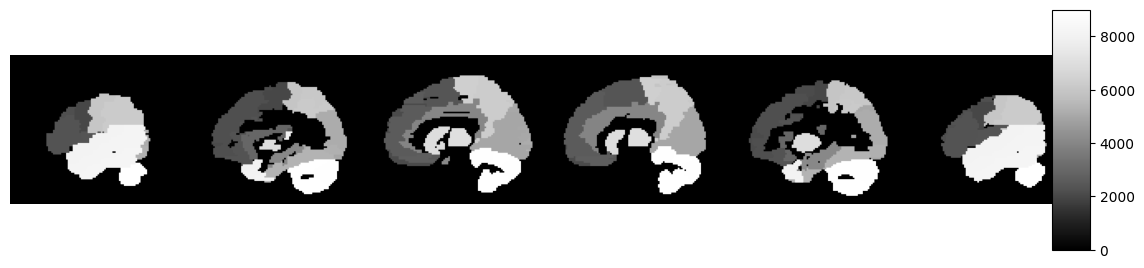

In [9]:
aal = datasets.fetch_atlas_aal(version='SPM12', data_dir=os.path.join(CACHE_DIR,"atlases"))
aal_img = ants.image_read(aal.maps, pixeltype='unsigned int')
aal_img.set_spacing((1.0,1.0,1.0))
aal_img.plot(nslices=6, cbar=True)

In [10]:
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=aal_img,
                             type_of_transform = 'SyN', interpolator="nearest")
aal_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=aal_img,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
aal_transformed

['-d', '3', '-i', '0x55d291cf00a0', '-o', '0x55d28dc167c0', '-r', '0x55d28d4ece30', '-n', 'multiLabel', '-t', '/tmp/tmpp75gtbb91Warp.nii.gz', '-t', '/tmp/tmpp75gtbb90GenericAffine.mat']
Using single precision for computations.
Input scalar image: 0x55d291cf00a0
Reference image: 0x55d28d4ece30
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmpp75gtbb90GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmpp75gtbb91Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x55d28dc167c0


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

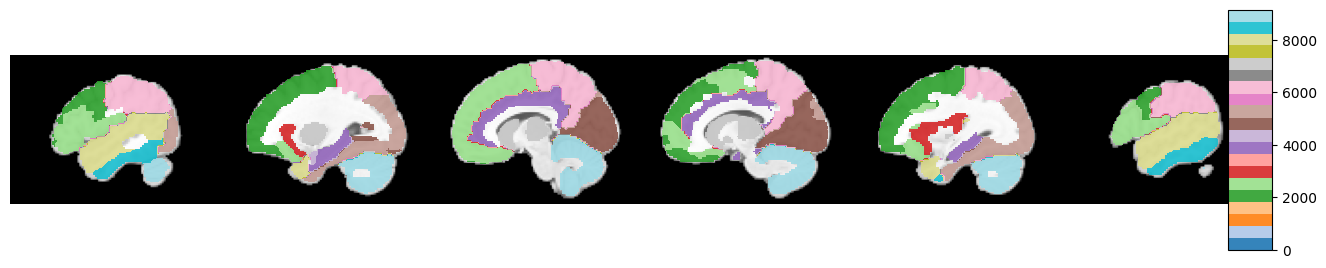

In [11]:
ref_img_post_transform.plot(overlay=aal_transformed, nslices=6, cbar=True, overlay_cmap="tab20")

In [12]:
%%time
atropos_precomputed_path = "/ASD/ahsan_projects/braintypicality/dataset/template_cache/atropos.nii.gz"
if os.path.exists(atropos_precomputed_path):
    atropos = ants.image_read(atropos_precomputed_path)
else:
    t1_ref_img, _ = ants.image_read(procd_ref_img_path).split_channels()
    atropos = antspynet.utilities.deep_atropos(t1_ref_img, do_preprocessing=True, verbose=False)
    atropos['segmentation_image'].to_filename(atropos_precomputed_path)
    x = atropos['probability_images'][1]
    x.plot(cmap="jet", cbar=True)

atropos_img = ants.resample_image(atropos, ref_img_post_transform.shape, use_voxels=True, interp_type=1)
atropos_img.set_spacing((1.0,1.0,1.0))
reg_dict = ants.registration(fixed=ref_img_post_transform, moving=atropos_img,
                             type_of_transform = 'SyN', interpolator="nearest")
atropos_transformed = ants.apply_transforms(
        fixed=ref_img_post_transform, moving=atropos_img,
        transformlist=reg_dict["fwdtransforms"], interpolator="multiLabel",
    verbose=True
)
atropos_post = img_and_label_loader({"image": procd_ref_img_path, "label": atropos_precomputed_path})["label"][0].numpy()
atropos_post = ants.from_numpy(atropos_post)
atropos_post

['-d', '3', '-i', '0x55d291536a40', '-o', '0x55d28c6e8ce0', '-r', '0x55d291532df0', '-n', 'multiLabel', '-t', '/tmp/tmpsyfdukz01Warp.nii.gz', '-t', '/tmp/tmpsyfdukz00GenericAffine.mat']
Using single precision for computations.
Input scalar image: 0x55d291536a40
Reference image: 0x55d291532df0
The composite transform comprises the following transforms (in order): 
  1. /tmp/tmpsyfdukz00GenericAffine.mat (type = AffineTransform)
  2. /tmp/tmpsyfdukz01Warp.nii.gz (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LabelImageGaussianInterpolateImageFunction
Output warped image: 0x55d28c6e8ce0
CPU times: user 27.2 s, sys: 1.39 s, total: 28.6 s
Wall time: 3.66 s


ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (96, 112, 80)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [13]:
ATLAS = "AAL+CSF"
CSF = 1

match ATLAS:
    case "AAL":
        parcellation = aal_transformed.numpy().astype(int)
        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        # Manually adding background
        parcellation_labels_map[0] = "background"
        parcellation_indices = np.unique(parcellation)
    case "AAL+CSF":
        parcellation = aal_transformed.numpy().astype(int)
        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        
        # Manually adding background + CSF
        parcellation_labels_map[0] = "background"
        
        # Including deep atropos CSF segmentation
        csf_label = (atropos_transformed  * BRAIN_MASK) == CSF
        csf_label = csf_label.numpy().astype(int)
        # Remove regions where there is an AAL labels 
        parcellation = csf_label * (parcellation == 0) + parcellation
        # I checked - there is n o label "1" in the given AAL
        parcellation_labels_map[1] = "CSF"
        
        parcellation_indices = np.unique(parcellation)
        
    case "AAL+Harvard":
        parcellation = aal_transformed.numpy().astype(int)
        subcorticals = harvard_subcortical_labels_transformed.numpy().astype(int)

        subcortical_mask = np.ones_like(subcorticals)
        skip_labels = [0,1,2, 12,13] # These look like cortical regions
        for i in skip_labels:
            subcortical_mask[subcortical_mask==i] = 0
        subcort_mask = subcortical_mask > 0

        parcellation = parcellation * ~subcort_mask + subcorticals * subcort_mask

        parcellation_labels_map = {int(k):v for k,v in zip(aal.indices,aal.labels)}
        for i,label in enumerate(harvard_oxford_subcortical.labels):
            parcellation_labels_map[i] = label
        parcellation_indices = np.unique(parcellation)

    case "DKT":
        dkt_parcellation = dkt_post.numpy().astype(int)
        region_idxs = np.unique(dkt_parcellation)
    case _:
        print("SELECT VALID ATLAS")

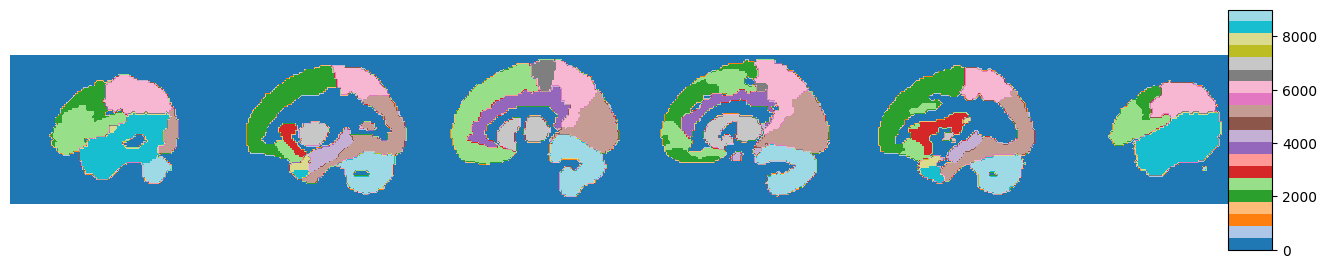

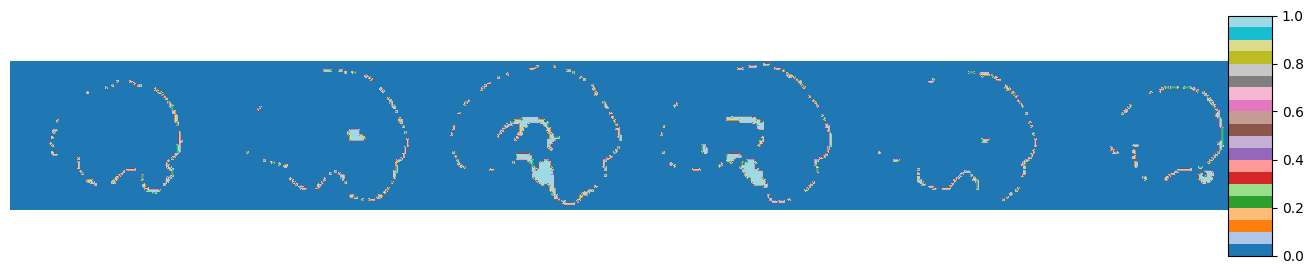

In [14]:
ants.from_numpy(parcellation.astype(float)).plot(nslices=6, cmap="tab20", cbar=True)
ants.from_numpy((parcellation == CSF).astype(float)).plot(nslices=6, cmap="tab20", cbar=True)

### Load the data

In [15]:
dataset_dir = config.data.dir_path
# Directory that holds files with train/test splits and other filenames
splits_dir = config.data.splits_dir = "/ASD/ahsan_projects/braintypicality/dataset/dataset_split_builder/"
config.data

cache_rate: 0.0
dataset: ABCD
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
image_size: !!python/tuple
- 96
- 112
- 80
num_channels: 2
spacing_pix_dim: 2.0
splits_dir: /ASD/ahsan_projects/braintypicality/dataset/dataset_split_builder/

In [16]:
filenames_for_ids = {}

for cohort in ['abcd-train', 'abcd-val', 'abcd-test',
               'ibis-inlier', 'ibis-hr-inlier', 'ibis-atypical',
               'ibis-asd', 'ibis-ds-sa'
              ]:
    filenames_for_ids[cohort] = get_image_files_list(cohort, dataset_dir, splits_dir)

In [17]:
%%time

experiment = config.eval.experiment

experiment.train = "ibis-inlier"
experiment.inlier = "ibis-atypical"
experiment.ood = "ibis-asd"
experiment_name = f"{experiment.train}_{experiment.inlier}_{experiment.ood}-raw"

cohort_to_experiment = {}
cohort_to_experiment[experiment.train] = (experiment_name, 'eval_score_norms')
cohort_to_experiment[experiment.inlier] = (experiment_name, 'inlier_score_norms')
cohort_to_experiment[experiment.ood] = (experiment_name, 'ood_score_norms')

experiment.train = "abcd-test"
experiment.inlier = "ibis-hr-inlier"
experiment.ood = "ibis-ds-sa"
experiment_name = f"{experiment.train}_{experiment.inlier}_{experiment.ood}-raw"

cohort_to_experiment[experiment.train] = (experiment_name, 'eval_score_norms')
cohort_to_experiment[experiment.inlier] = (experiment_name, 'inlier_score_norms')
cohort_to_experiment[experiment.ood] = (experiment_name, 'ood_score_norms')

CPU times: user 74 µs, sys: 0 ns, total: 74 µs
Wall time: 84.2 µs


In [33]:
experiment.train = "abcd-val"
experiment.inlier = "abcd-val"
experiment.ood = "abcd-val"
experiment_name = f"{experiment.train}_{experiment.inlier}_{experiment.ood}-raw"

cohort_to_experiment[experiment.train] = (experiment_name, 'eval_score_norms')

## Compute Lobe Score Norms

In [20]:
aal_lobes = pd.read_csv('/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/aal_labels_lobe.csv')
aal_lobes_to_index = aal_lobes.groupby('Lobe')['ROI-Index']

In [21]:
def register_to_mni(x:np.ndarray, fname: str, multichannel=False):
    sampleid = os.path.basename(fname).split(".nii.gz")[0]
    transform_mat = f"{transforms_dir}/{sampleid}Composite.h5"
    
    if multichannel:
        x = x.transpose(1,2,3,0)
        x = ants.from_numpy(x)

        return ants.apply_transforms(
            fixed=ref_img_post_transform, interpolator="linear", verbose=False,
            moving=x, transformlist=transform_mat, imagetype = 3
        ).numpy().transpose(3,0,1,2)
        
    x = ants.from_numpy(x)
    return ants.apply_transforms(
        fixed=ref_img_post_transform, interpolator="linear", verbose=False,
        moving=x, transformlist=transform_mat
    ).numpy()

In [22]:
from tqdm.auto import tqdm

In [34]:
# %%time

for cohort, (experiment_name, fname) in tqdm(cohort_to_experiment.items()):
    
    if cohort != "abcd-val": continue
    
    print(f"Calculating Lobe Score Norms for {cohort}")
    cohort_score_norms = []
    
    with np.load(f"{workdir}/eval/ckpt_1500002/smin=0.01_smax=0.80_t=20/{experiment_name}_results.npz",
                 allow_pickle=True) as data:
        scores = data[fname]
        
        for i, s in enumerate(scores):
            aligned_score = register_to_mni(s, filenames_for_ids[cohort][i]['image'], multichannel=True)

            coarse_score_norms = []
            for lobe, roi_idxs in aal_lobes_to_index:
                lobe_scores = np.concatenate([aligned_score[:, parcellation == idx] for idx in roi_idxs],axis=1)
                lobe_score_norm = np.linalg.norm(lobe_scores, axis=1)
                coarse_score_norms.append(lobe_score_norm)

            csf_norm = np.linalg.norm(aligned_score[:, parcellation == CSF], axis=1)
            coarse_score_norms.append(csf_norm)
            coarse_score_norms = np.concatenate(coarse_score_norms)

            cohort_score_norms.append(coarse_score_norms)
        cohort_score_norms = np.stack(cohort_score_norms, axis=0)
        np.savez_compressed(f"/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/{cohort}_lobe_score_norms.npz", cohort_score_norms)

  0%|          | 0/7 [00:00<?, ?it/s]

Calculating Lobe Score Norms for abcd-val


100%|██████████| 7/7 [03:56<00:00, 33.74s/it]


In [32]:
for cohort in cohort_to_experiment:
    fname = f"/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/eval/heatmaps_v2/{cohort}_lobe_score_norms.npz"
    print(cohort, "->", np.load(fname, allow_pickle=True)['arr_0'].shape)

ibis-inlier -> (82, 360)
ibis-atypical -> (38, 360)
ibis-asd -> (65, 360)
abcd-test -> (165, 360)
ibis-hr-inlier -> (106, 360)
ibis-ds-sa -> (28, 360)


In [24]:
cohort_score_norms.shape

(28, 360)

<Axes: >

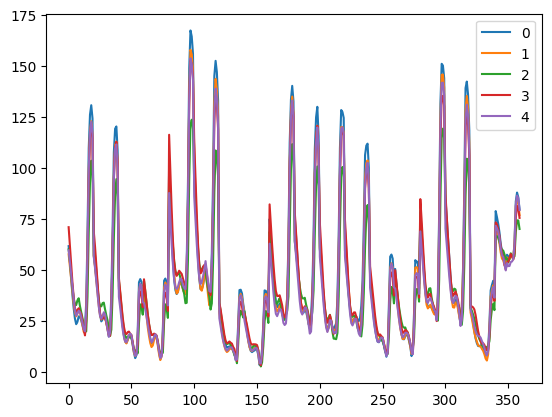

In [25]:
pd.DataFrame(cohort_score_norms[:5]).T.plot()